# Pneumonia Detection from Chest X-Rays

## Exploratory Data Analysis (EDA)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from collections import Counter
from PIL import Image, ImageOps

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
7053,00001861_001.png,No Finding,1,1861,37,M,PA,2992,2733,0.143,0.143,NaN
105529,00028366_001.png,No Finding,1,28366,47,M,PA,3056,2544,0.139,0.139,NaN
83047,00020408_020.png,No Finding,20,20408,45,M,AP,3056,2544,0.139,0.139,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3292,00016246_000.png,No Finding,0,16246,059Y,M,PA,2530,2762,0.143,0.143
5189,00027725_073.png,Emphysema|Pneumonia|Pneumothorax,73,27725,021Y,M,AP,3056,2544,0.139,0.139
2195,00011365_002.png,No Finding,2,11365,057Y,M,AP,2500,2048,0.168,0.168


## Exploratory Data Analysis

We first check if all rows in `all_xray_df` can be matched to all rows in `sample_df`. It shows that they don't have the same number of rows.

In [4]:
print("Number of rows in all_xray_df: {}".format(all_xray_df.shape[0]))
print("Number of rows in sample_df: {}".format(sample_df.shape[0]))
all_xray_df.shape[0] == sample_df.shape[0]

Number of rows in all_xray_df: 112120
Number of rows in sample_df: 5606


False

### About data (full NIH data)

We use the full NIH data (all_xray_df) to perform our EDA. The data contains 112,120 rows and 12 columns.

Images are collected from 30,805 unique patients (indexing from 1 to 30,805).

In [5]:
# number of rows and columns in data
print("Shape of all_xray_df: {}\n".format(all_xray_df.shape))

# number of unique image
print("Unique Image Index: {}\n".format(all_xray_df['Image Index'].nunique()))

# number of unique patient IDs and their min/max
print("Unique patient IDs: {}".format(len(all_xray_df['Patient ID'].unique())))
print("Min patient ID: {}".format(all_xray_df['Patient ID'].min()))
print("Max patient ID: {}\n".format(all_xray_df['Patient ID'].max()))

Shape of all_xray_df: (112120, 12)

Unique Image Index: 112120

Unique patient IDs: 30805
Min patient ID: 1
Max patient ID: 30805



Patients can have multiple images. I used `collections.Counter` to see the distribution of the number of images taken from each patients.

Among all 30,805 patients:
- 17,503 patients have only 1 image taken
- 4,113 patients have 2 images taken
- 2,100 patients have 3 images taken
- 1,330 patients have 4 images taken
- 87,074 patients have more than 5 images taken

There are some (n=157) patients that have taken more than 50 images. The maximum number of images taken is 184, taken from Patient #10007

In [6]:
groupby_patientID_counts = all_xray_df.groupby('Patient ID').size()
groupby_patientID_counts.head()

Patient ID
1    3
2    1
3    8
4    1
5    8
dtype: int64

In [7]:
# convert counts to a dictionary, (key, value) = (number of images taken, number of patients)
num_image_each_patient_dict = Counter(groupby_patientID_counts.to_numpy())
print(sorted(num_image_each_patient_dict.items(), key=lambda x: x[1], reverse=True))

[(1, 17503), (2, 4113), (3, 2100), (4, 1330), (5, 938), (6, 787), (7, 608), (8, 494), (9, 387), (10, 320), (11, 281), (12, 235), (14, 181), (13, 165), (15, 121), (16, 120), (17, 91), (18, 77), (19, 77), (20, 74), (21, 68), (24, 51), (23, 50), (25, 45), (22, 39), (27, 38), (26, 35), (30, 28), (28, 27), (29, 25), (35, 24), (34, 23), (32, 22), (33, 20), (31, 17), (38, 16), (41, 14), (40, 12), (39, 11), (51, 11), (37, 11), (42, 11), (55, 10), (46, 10), (49, 9), (61, 8), (44, 8), (36, 8), (56, 7), (54, 7), (62, 7), (52, 7), (48, 7), (66, 6), (69, 6), (50, 6), (45, 6), (43, 6), (47, 5), (53, 5), (68, 4), (58, 4), (59, 3), (67, 3), (81, 3), (86, 3), (108, 3), (65, 3), (60, 3), (64, 3), (63, 3), (70, 2), (116, 2), (77, 2), (80, 2), (73, 2), (71, 2), (57, 2), (76, 2), (84, 2), (90, 2), (137, 1), (87, 1), (102, 1), (89, 1), (83, 1), (184, 1), (75, 1), (88, 1), (79, 1), (157, 1), (173, 1), (143, 1), (158, 1), (99, 1), (117, 1), (111, 1), (91, 1), (130, 1), (119, 1), (109, 1), (114, 1), (74, 1)]


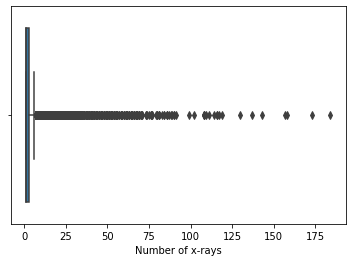

In [8]:
groupby_patientID_counts = all_xray_df.groupby('Patient ID').size()

# box plot of number of images from each patient
ax = sns.boxplot(groupby_patientID_counts)
ax.set_xlabel("Number of x-rays")
plt.show()

In [9]:
# number of unique patients that have taken more than 50 images
print("{} patients have more than 50 images\n".format(sum(groupby_patientID_counts>=50)))
# the patient have have taken the most images
max_num_images_taken = groupby_patientID_counts.max()
max_num_images_taken_pid = groupby_patientID_counts[groupby_patientID_counts == max_num_images_taken].index.values
print("Max number of images taken is {}, from the patient(s): {}".format(max_num_images_taken, max_num_images_taken_pid))

157 patients have more than 50 images

Max number of images taken is 184, from the patient(s): [10007]


**About View Position**

We see that the `View Position` can take 2 values: `PA` and `AP`. Differences between PA and AP images are discussed in this webpage https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection.

In [10]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

We see if for each patient there can be more than 1 view position. From below it shows that for the same patient, both view positions might be found (for example, for the patient with ID = 5)

In [11]:
groupby_patientID_df = all_xray_df.groupby('Patient ID')
groupby_patientID_df = groupby_patientID_df.agg({'View Position': "nunique"})
groupby_patientID_df.head()

,View Position
Patient ID,
1,1
2,1
3,1
4,1
5,2


### Patient demography

The EDA in this section analyzed the patient demographic data such as gender and age. We first create a DataFrame with columns we're interested in. We also only select the first encounter for each patient (by only taking `Follow-up # = 0`).

In [12]:
# check if every patient has a row with `Follow-up #` = 0
if np.empty(np.setdiff1d(all_xray_df['Patient ID'].unique(),
                         all_xray_df[all_xray_df['Follow-up #']==0]['Patient ID'].unique())):
    print("We can always find a row of the initial visit for every patient")

We can always find a row of the initial visit for every patient


In [13]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [14]:
demography_df = all_xray_df[all_xray_df['Follow-up #']==0][['Patient ID','Patient Age', 'Patient Gender']]
print("Number of patients: {}".format(demography_df.shape[0]))
demography_df.head()

Number of patients: 30805


,Patient ID,Patient Age,Patient Gender
0,1,58,M
3,2,81,M
4,3,81,F
12,4,82,M
13,5,69,F


### Patient demography: Age

We see that there is an data with age 412 in the dataset. This data might have some problems.

In [15]:
print("Max of age: {}".format(demography_df['Patient Age'].max()))
print("Min of age: {}".format(demography_df['Patient Age'].min()))

Max of age: 412
Min of age: 1


In [16]:
over_100yo_df = demography_df[demography_df['Patient Age']>100]
print("Number of patients older than 100 years old: {}".format(over_100yo_df.shape[0]))
over_100yo_df

Number of patients older than 100 years old: 8


,Patient ID,Patient Age,Patient Gender
20852,5567,412,M
55742,13950,148,M
62929,15558,149,M
78795,19346,151,F
91369,22811,412,M
95794,25206,153,M
101194,26871,155,F
104590,27989,155,M


These data look suspicious. I therefore decided to remove these 8 patients from the dataset (and all the following EDA and training).

In [17]:
valid_patient_ids = np.setdiff1d(demography_df['Patient ID'].unique(), over_100yo_df['Patient ID'].unique())
print("Number of valid patients: {}".format(len(valid_patient_ids)))

Number of valid patients: 30797


In [18]:
demography_df = demography_df[demography_df['Patient ID'].isin(valid_patient_ids)]
print(demography_df['Patient ID'].nunique())

30797


After removing patients older than 100 years old, we plot the histogram of the age.

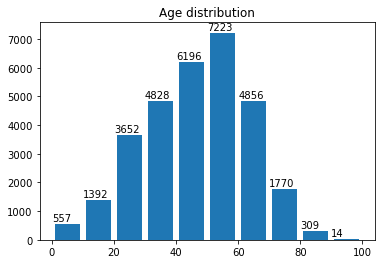

In [19]:
age_bins = list(range(0, 110, 10))

ax = plt.subplot()
age_hist_counts = plt.hist(x="Patient Age", bins=age_bins, data=demography_df, rwidth=0.8)
for i in range(len(age_bins)-1):
    plt.text(age_hist_counts[1][i], age_hist_counts[0][i]+100, str(int(age_hist_counts[0][i])))
ax.set_title("Age distribution")
plt.show()

### Patient demography: Gender

Out of 30,797 patients, 16,624 are male and 14,173 are female.

Number of male patients: 16624
Number of female patients: 14173


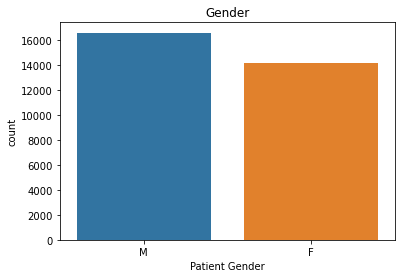

In [20]:
print("Number of male patients: {}".format(sum(demography_df['Patient Gender']=='M')))
print("Number of female patients: {}".format(sum(demography_df['Patient Gender']=='F')))

# plot
ax = sns.countplot(x="Patient Gender", data=demography_df)
ax.set_title("Gender")
plt.show()

### View position

Among all 112,068 images (we removed images from patients older than 100 years old), there are 44,792 AP chest X-rays and 67,276 chest X-rays.

In [21]:
all_xray_df = all_xray_df[all_xray_df['Patient ID'].isin(valid_patient_ids)]

Number of all X-rays: 112068
Number of AP X-rays: 44792
Number of PA X-rays: 67276


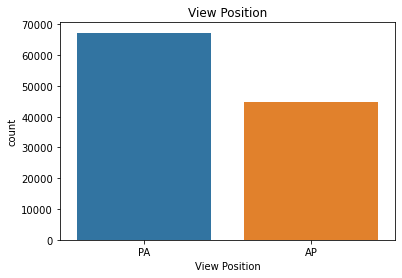

In [22]:
print("Number of all X-rays: {}".format(all_xray_df.shape[0]))
print("Number of AP X-rays: {}".format(sum(all_xray_df['View Position']=='AP')))
print("Number of PA X-rays: {}".format(sum(all_xray_df['View Position']=='PA')))

# plot
ax = sns.countplot(x="View Position", data=all_xray_df)
ax.set_title("View Position")
plt.show()

### Number of pneumonia cases

The `Finding Labels` column can contain multiple diagnoses separated by the `|` character. I created a column called `pneumonia_class`, with `positive` indicating the pneumonia is detected, and `negative` indicating pneumonia is not found.

In [23]:
all_xray_df["Finding Labels"].unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

Number of images with pneumonia: 1426
Number of images without pneumonia: 110642


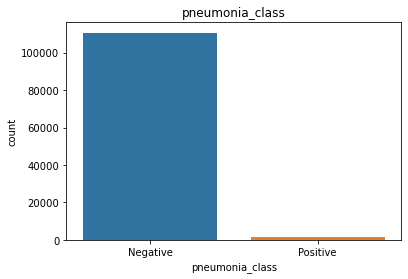

In [24]:
# create a 'pneumonia_class' column where 1: with pneumonia and 0: without pneumonia
all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].str.contains("Pneumonia")

# convert True/False into 1/0
all_xray_df['pneumonia_class'] = all_xray_df['pneumonia_class'].replace({True: "Positive", False: "Negative"})

# number of image that has/doesn't have pneumonia
print("Number of images with pneumonia: {}".format(sum(all_xray_df['pneumonia_class'] == "Positive")))
print("Number of images without pneumonia: {}".format(sum(all_xray_df['pneumonia_class'] == "Negative")))

# plot
ax = sns.countplot(x="pneumonia_class", data=all_xray_df)
ax.set_title("pneumonia_class")
plt.show()

We see that the dataset is unbalanced. We only have 1,426 pneumonia-positive images, which is 1% of the whole dataset.

### Diseases comorbid with pneumonia

There are 15 distinct diseases/diagnoses in the `Finding Labels` column.

- No Finding
- Edema
- Mass
- Cardiomegaly
- Infiltration
- Pneumothorax
- Consolidation
- Hernia
- Atelectasis
- Fibrosis
- Emphysema
- Effusion
- Nodule
- Pleural_Thickening
- Pneumonia

In [25]:
disease_set = set()

for diagnosis in all_xray_df['Finding Labels'].unique():
    for disease in diagnosis.split("|"):
        disease = disease.strip()
        disease_set.add(disease)

print(disease_set)

{'Mass', 'Infiltration', 'Consolidation', 'Edema', 'Pneumothorax', 'Hernia', 'Atelectasis', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Cardiomegaly', 'No Finding', 'Effusion', 'Nodule', 'Emphysema'}


We go through every pneumonia-positive rows and see what other diseases are comorbid with pneumonia.

In [26]:
# create a dict to count comorbid
comorbid_diseases = dict()
for dis in disease_set:
    if dis not in ["No Finding", "Pneumonia"]:
        comorbid_diseases[dis] = 0

# iterate the rows
for i in range(all_xray_df.shape[0]):
    if all_xray_df.iloc[i]['pneumonia_class'] == "Positive":
        diseases = all_xray_df.iloc[i]['Finding Labels']
        for dis in diseases.split("|"):
            dis = dis.strip()
            if dis not in ["No Finding", "Pneumonia"]:
                comorbid_diseases[dis] += 1

print(comorbid_diseases)

{'Mass': 71, 'Infiltration': 605, 'Consolidation': 123, 'Edema': 340, 'Pneumothorax': 41, 'Hernia': 3, 'Atelectasis': 261, 'Pleural_Thickening': 48, 'Fibrosis': 11, 'Cardiomegaly': 41, 'Effusion': 267, 'Nodule': 70, 'Emphysema': 22}


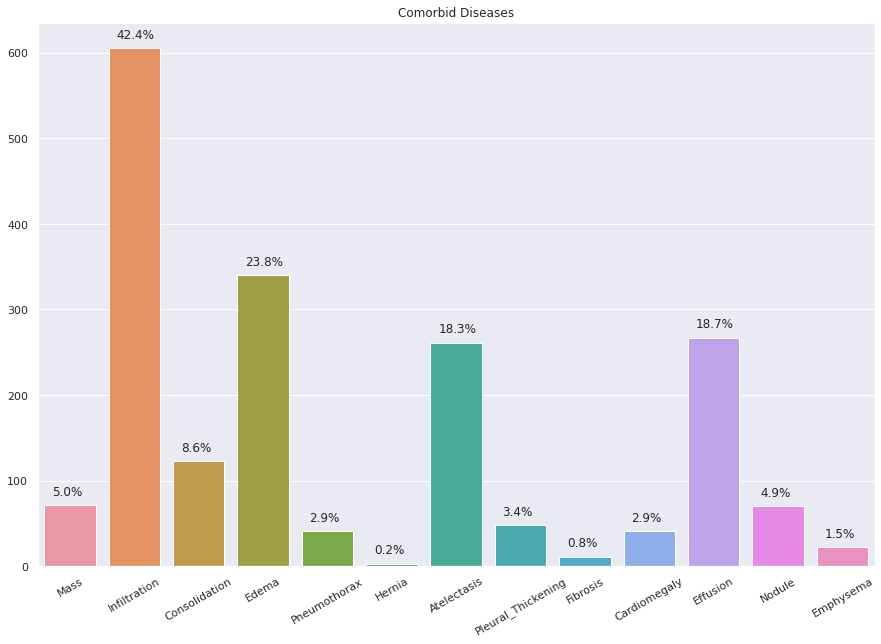

In [27]:
# plot
comorbid_dis = list(comorbid_diseases.keys())
comorbid_counts = list(comorbid_diseases[x] for x in comorbid_diseases.keys())
comorbid_freq = [100*x/1426 for x in comorbid_counts]

sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.barplot(x=comorbid_dis, y=comorbid_counts)
ax.set_title("Comorbid Diseases")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

for i, p in enumerate(ax.patches):
    ax.annotate("{:.1f}%".format(comorbid_freq[i]), (p.get_x()+p.get_width()/2, p.get_height()), 
                xytext=(-18, 10), textcoords='offset pixels')
    
plt.show()

The top 5 common diseases that accompany the diagnosis of pneumonia are:

- Infiltration (42.4%)
- Edema (23.8%)
- Effusion (18.7%)
- Atelectasis (18.3%)
- Consolidation (8.6%)

### Number of diseases comorbid with pneumonia

The barplot below shows the distribution of the number of comorbid diseases with pneumonia.

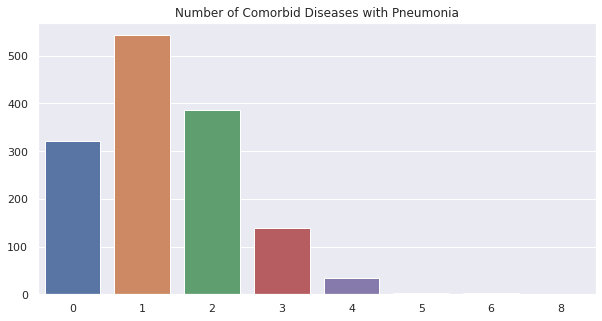

In [28]:
n_comorbid_dict = dict()

# iterate the rows
for i in range(all_xray_df.shape[0]):
    # only select the image where pneumonia is detected
    if all_xray_df.iloc[i]['pneumonia_class'] == "Positive":
        # the diagnoses
        diseases = all_xray_df.iloc[i]['Finding Labels']
        # split the diseases and (len-1) is the number of comorbid diseases
        n_comorbid = len(diseases.split("|"))-1
        n_comorbid_dict[n_comorbid] = n_comorbid_dict.get(n_comorbid, 0) + 1

# plot
sns.set(rc={'figure.figsize':(10, 5)})
ax = sns.barplot(x=list(n_comorbid_dict.keys()), y=list(n_comorbid_dict[x] for x in n_comorbid_dict.keys()))
ax.set_title("Number of Comorbid Diseases with Pneumonia")
ax.set_xticklabels(ax.get_xticklabels())
    
plt.show()

### Number of diseases per patient

Below shows the distribution of number of diseases per patient (images with `No Finding` are excluded)

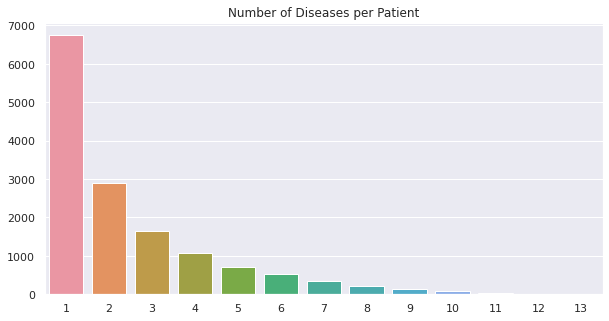

In [29]:
pid_to_num_diseases = dict()

# iterate the rows
for i in range(all_xray_df.shape[0]):
    if all_xray_df.iloc[i]['Finding Labels'] != "No Finding":
        pid = all_xray_df.iloc[i]['Patient ID']
        diseases = all_xray_df.iloc[i]['Finding Labels'].split("|")
        for d in diseases:
            d = d.strip()
            pid_to_num_diseases[pid] = pid_to_num_diseases.get(pid, []) + [d]

num_diseases_dict = dict()

for pid in pid_to_num_diseases:
    n_diseases = len(set(pid_to_num_diseases[pid]))
    num_diseases_dict[n_diseases] = num_diseases_dict.get(n_diseases, 0) + 1

# plot
n_diseases = list(num_diseases_dict.keys())
n_diseases_counts = list(num_diseases_dict[x] for x in num_diseases_dict.keys())

sns.set(rc={'figure.figsize':(10, 5)})
ax = sns.barplot(x=n_diseases, y=n_diseases_counts)
ax.set_title("Number of Diseases per Patient")
ax.set_xticklabels(ax.get_xticklabels())
    
plt.show()

### Number of patients detected with pneumonia

There are 30,797 unique patients. Among them, 1,007 patients are detected with pneumonia.

In [30]:
print("Total number of patients: {}".format(all_xray_df['Patient ID'].nunique()))
print("Number of patients with pneumonia: {}".format(all_xray_df[all_xray_df['pneumonia_class']=="Positive"]['Patient ID'].nunique()))

Total number of patients: 30797
Number of patients with pneumonia: 1007


### Pixel-level assessments

We use `sample_labels.csv` for pixel-level assessments. We should be careful that different images may have different shapes.

In [31]:
print(sample_df.shape)
sample_df.head()

(5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


We saw that there are also some 411 years-old data in this dataframe. We remove patient data older than 100 years-old.

In [32]:
sample_df['Patient Age'].unique()

array(['060Y', '057Y', '077Y', '079Y', '055Y', '068Y', '071Y', '063Y',
       '067Y', '056Y', '058Y', '075Y', '073Y', '054Y', '078Y', '047Y',
       '050Y', '045Y', '084Y', '030Y', '049Y', '061Y', '069Y', '051Y',
       '044Y', '087Y', '059Y', '031Y', '064Y', '053Y', '082Y', '072Y',
       '046Y', '080Y', '048Y', '021Y', '038Y', '062Y', '052Y', '023Y',
       '037Y', '022Y', '032Y', '070Y', '065Y', '040Y', '042Y', '041Y',
       '028Y', '035Y', '034Y', '066Y', '019Y', '039Y', '074Y', '026Y',
       '024Y', '085Y', '016Y', '029Y', '033Y', '013Y', '017Y', '020Y',
       '014Y', '043Y', '012Y', '009Y', '011Y', '027Y', '036Y', '081Y',
       '025Y', '018Y', '076Y', '083Y', '008Y', '006Y', '015Y', '002Y',
       '005Y', '010Y', '003Y', '089Y', '007Y', '086Y', '004Y', '094Y',
       '013M', '411Y', '001D', '088Y'], dtype=object)

In [33]:
sample_df = sample_df[sample_df['Patient Age'].str[:-1].astype(int) <= 100]
sample_df['Patient Age'].unique()

array(['060Y', '057Y', '077Y', '079Y', '055Y', '068Y', '071Y', '063Y',
       '067Y', '056Y', '058Y', '075Y', '073Y', '054Y', '078Y', '047Y',
       '050Y', '045Y', '084Y', '030Y', '049Y', '061Y', '069Y', '051Y',
       '044Y', '087Y', '059Y', '031Y', '064Y', '053Y', '082Y', '072Y',
       '046Y', '080Y', '048Y', '021Y', '038Y', '062Y', '052Y', '023Y',
       '037Y', '022Y', '032Y', '070Y', '065Y', '040Y', '042Y', '041Y',
       '028Y', '035Y', '034Y', '066Y', '019Y', '039Y', '074Y', '026Y',
       '024Y', '085Y', '016Y', '029Y', '033Y', '013Y', '017Y', '020Y',
       '014Y', '043Y', '012Y', '009Y', '011Y', '027Y', '036Y', '081Y',
       '025Y', '018Y', '076Y', '083Y', '008Y', '006Y', '015Y', '002Y',
       '005Y', '010Y', '003Y', '089Y', '007Y', '086Y', '004Y', '094Y',
       '013M', '001D', '088Y'], dtype=object)

### Pixel-value distributions

We plot the histograms of all **15 classes** of diagnosis/finding labels.

In [34]:
# help function to calculate pixel distribution from a single image
def pv_single_image(image_np, pv_bins):
    """
    Calculate the pixel value distribution from a single image
    Args:
        image_np: numpy array of the image
        pv_bins: bins to group pixel values
    """
    # return the indices of bins each pixel location belongs to
    # bins[i-1] < pix.val <= bins[i]
    image_digitized = np.digitize(image_np, pv_bins, right=False)
    
    # pixel-value distributions
    pvd = [0 for _ in range(len(pv_bins)-1)]
    
    h, w = image_np.shape
    for i in range(h):
        for j in range(w):
            pvd[image_digitized[i][j]-1] += 1
            
    # normalize
    pvd /= np.sum(pvd)
    
    return pvd

In [35]:
# process the paths of the images
img_decoded_paths = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}

# add path to the image to the dataframe
sample_df['image_path'] = sample_df['Image Index'].map(img_decoded_paths.get)
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,image_path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_001.png


### Data processing for pixel value distribution analysis

The cells below processes all the images by grouping the pixel values into bins and stored into a dataframe.

For each disease, we randomly select 50 images to see the pixel values distributions.

In [102]:
# pixel value bins
pv_bins = list(range(0, 280, 20))
n_pv_bins = len(pv_bins)
print("pixel-value bins: {}".format(pv_bins))

pixel-value bins: [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]


In [103]:
# create a list of categorical column names for the pixel level bins
bin_names = []
for bin_min, bin_max in zip(pv_bins[:-1], pv_bins[1:]):
    bmin = str(bin_min)
    bmax = str(bin_max)
    bin_names.append(bmin + "-" + bmax)
print(bin_names)

['0-20', '20-40', '40-60', '60-80', '80-100', '100-120', '120-140', '140-160', '160-180', '180-200', '200-220', '220-240', '240-260']


In [104]:
# create a dict to store pixel value information for creating a dataframe
# pv_df_dict has keys such as: 'disease_class',  '0-20', '20-40', ..., '240-260'
pv_df_dict = {'disease_class': []}
for x in bin_names:
    pv_df_dict[x] = []
print(pv_df_dict)

{'disease_class': [], '0-20': [], '20-40': [], '40-60': [], '60-80': [], '80-100': [], '100-120': [], '120-140': [], '140-160': [], '160-180': [], '180-200': [], '200-220': [], '220-240': [], '240-260': []}


In [105]:
np.random.seed(2)

n_sample = 20

# loop over diseases, for each disease, random select n_sample images
for disease in disease_set:
    # filter the dataframe by the presence of the disease
    images_paths = sample_df[sample_df['Finding Labels'].str.contains(disease)]['image_path'].to_numpy()
    # random select n_sample images
    np.random.shuffle(images_paths)
    if len(images_paths) > n_sample:
        images_paths = images_paths[:n_sample]
    for img_pth in images_paths:
        # open image
        image = Image.open(img_pth)
        # convert to numpy array
        image_np = np.array(ImageOps.grayscale(image))
        # binning the pixel values
        pvd = pv_single_image(image_np, pv_bins).tolist()
        # add to dict
        pv_df_dict['disease_class'].append(disease)
        for bin_name, val in zip(bin_names, pvd):
            pv_df_dict[bin_name].append(val)
    print("{} images sampled from class = {}".format(len(images_paths), disease))

20 images sampled from class = Mass
20 images sampled from class = Infiltration
20 images sampled from class = Consolidation
20 images sampled from class = Edema
20 images sampled from class = Pneumothorax
13 images sampled from class = Hernia
20 images sampled from class = Atelectasis
20 images sampled from class = Pleural_Thickening
20 images sampled from class = Pneumonia
20 images sampled from class = Fibrosis
20 images sampled from class = Cardiomegaly
20 images sampled from class = No Finding
20 images sampled from class = Effusion
20 images sampled from class = Nodule
20 images sampled from class = Emphysema


In [106]:
# create the dataframe
pv_df = pd.DataFrame.from_dict(pv_df_dict)
pv_df.head()

,disease_class,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200,200-220,220-240,240-260
0,Mass,0.139098,0.018038,0.043544,0.067974,0.074322,0.096088,0.120270,0.128380,0.081369,0.070438,0.075747,0.077433,0.007298
1,Mass,0.073778,0.034536,0.064992,0.087893,0.094806,0.074899,0.076587,0.099896,0.104612,0.119841,0.143292,0.019182,0.005686
2,Mass,0.202061,0.032505,0.069072,0.102118,0.091829,0.084945,0.079726,0.093923,0.077390,0.062024,0.070806,0.031918,0.001684
3,Mass,0.054419,0.032680,0.070300,0.090703,0.079377,0.071861,0.082346,0.102184,0.125918,0.107511,0.100795,0.077494,0.004413
4,Mass,0.087930,0.015428,0.020774,0.047260,0.120593,0.126686,0.105385,0.129649,0.167704,0.098209,0.063197,0.016809,0.000377


In [107]:
pv_df_mean = pv_df.groupby('disease_class', as_index=False).agg('mean')
print(pv_df_mean.shape)
pv_df_mean.head()

(15, 14)


,disease_class,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200,200-220,220-240,240-260
0,Atelectasis,0.061026,0.027394,0.046001,0.059602,0.074979,0.087385,0.112965,0.111311,0.118529,0.126841,0.101545,0.067974,0.004447
1,Cardiomegaly,0.064509,0.028296,0.034229,0.060423,0.098227,0.122131,0.138126,0.109141,0.080617,0.094322,0.100556,0.068182,0.001242
2,Consolidation,0.104076,0.039112,0.047843,0.069725,0.092425,0.104172,0.111962,0.114990,0.112507,0.104218,0.066793,0.031207,0.000971
3,Edema,0.097127,0.024746,0.039996,0.075451,0.119187,0.142847,0.150297,0.128188,0.094896,0.075885,0.043560,0.007323,0.000496
4,Effusion,0.090451,0.040388,0.053517,0.070165,0.087164,0.092917,0.104546,0.109274,0.106524,0.097322,0.086368,0.051568,0.009795


In [108]:
pv_df_std = pv_df.groupby('disease_class', as_index=False).agg(['std'])
print(pv_df_mean.shape)
pv_df_std.head()

(15, 14)


,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200,200-220,220-240,240-260
,std,std,std,std,std,std,std,std,std,std,std,std,std
disease_class,,,,,,,,,,,,,
Atelectasis,0.048141,0.018371,0.032697,0.031712,0.031573,0.037155,0.060739,0.039640,0.050249,0.065245,0.057347,0.063455,0.009954
Cardiomegaly,0.052503,0.016207,0.021297,0.031160,0.044321,0.054242,0.083242,0.037522,0.044890,0.056880,0.078673,0.075759,0.001745
Consolidation,0.074360,0.017355,0.025067,0.034094,0.046651,0.042469,0.030304,0.046271,0.041521,0.046694,0.060169,0.043448,0.001387
Edema,0.088511,0.013859,0.018074,0.036489,0.052622,0.036869,0.045580,0.053121,0.041824,0.040973,0.036718,0.014563,0.000497
Effusion,0.055940,0.023418,0.028010,0.029406,0.042927,0.041444,0.052271,0.042623,0.051862,0.049262,0.059891,0.076722,0.024128


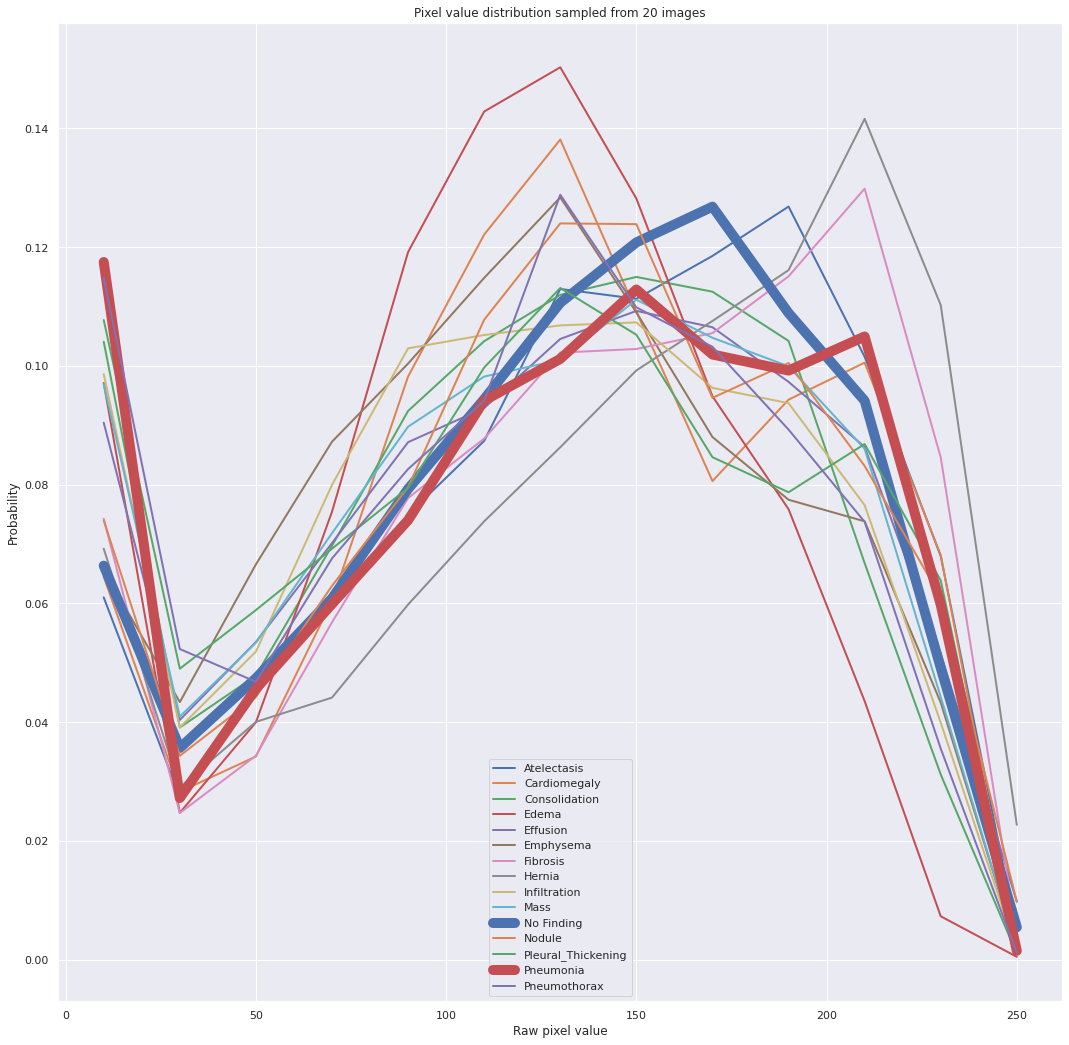

In [109]:
plt.figure(figsize=(18, 18))
x = list(range(10, 270, 20))
for i in range(pv_df_mean.shape[0]):
    row_data = pv_df_mean.iloc[i].values
    disease = row_data[0]
    pv_means = row_data[1:]
    if disease in ['No Finding', 'Pneumonia']:
        plt.plot(x, pv_means, label=disease, linewidth=10)
    else:
        plt.plot(x, pv_means, label=disease, linewidth=2)
    plt.legend()
    
plt.title("Pixel value distribution sampled from {} images".format(n_sample))
plt.xlabel("Raw pixel value")
plt.ylabel("Probability")
plt.show()

## Conclusion

My findings are:

1. There are some suspicious data with age larger than 100 years-old. Those data will be removed from future training.

2. The data is not balanced. Only ~3% of the patients have neumonia in the dataset.

3. The gender ratio of the dataset is roughly M:F = 8:7

4. The age distribution is bell-like. Most of the images are taken from ages 30-70.

5. We have 2:3 AP:PA X-rays.

6. Infiltration, edema, effusion, atelectasis, and consolidation are common comorbid diseases of pneumonia.

7. From the pixel-level analysis, images with diseases have higher counts of low-value pixels (raw values 0-20). `No Finding` data seem to have more pixels with value 150-200 than `pneumonia` data.

Due to the observations made above, during the training I'll:

1. Remove suspicious data
2. Make the training dataset balanced by equal portions of positive and negative data.
3. Make the validation dataset 1 negative data : 4 positive data.
3. Study the biases and the fairness of the model on gender, age, view position, and any comorbid diseases after training.